In [3]:
import pandas as pd
train=pd.read_csv("../input/image-dataset/train.csv")
val=pd.read_csv("../input/image-dataset/val.csv")

In [9]:
val.head()

,Image_Path,Class
0,Validation/Table/2015_07109.jpg,Table
1,Validation/Cat/2015_03292.jpg,Cat
2,Validation/People/2015_06549.jpg,People
3,Validation/Bicycle/2015_00310.jpg,Bicycle
4,Validation/Table/2015_07105.jpg,Table


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 


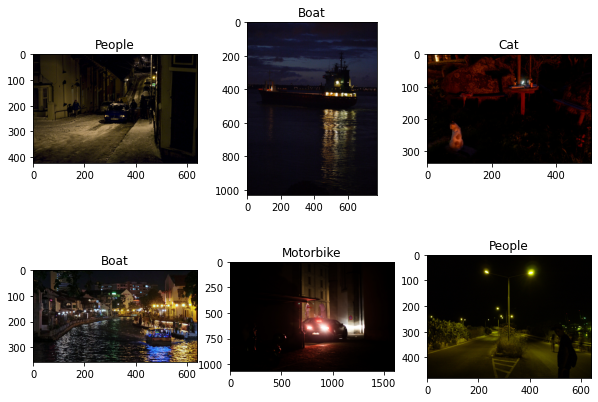

In [47]:

import matplotlib.image as mpimg
fig=plt.figure(figsize=(10,7))
r=2
c=3
for i in range(1,7):
    fig.add_subplot(r,c,i)
    plt.title(train['Class'][i])
    plt.imshow(mpimg.imread('../input/image-datasets/'+train['Image_Path'][i]))






In [11]:
dict={"Motorbike":0,'People':1, 'Boat':2, 'Cat':3, 'Table':4, 'Bicycle':5}
y=train["Class"].map(dict)
#train_y
val_y=val['Class'].map(dict)

In [12]:
train_image = []
for i in (range(train.shape[0])):
    img = image.load_img('../input/image-datasets/'+train['Image_Path'][i], target_size=(256,256,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

val_image = []
for i in (range(val.shape[0])):
    img = image.load_img('../input/image-datasets/'+val['Image_Path'][i], target_size=(256,256,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    val_image.append(img)
X_val = np.array(val_image)



In [13]:

y=to_categorical(y)

y_val=to_categorical(val_y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
img_h=256

img_w=256

In [15]:
# ImageDataGenerator (in-place augmentation)
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    )
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    )



In [16]:
it_train=train_data_gen.flow(X_train,y_train,batch_size=16)
it_val=valid_data_gen.flow(X_test,y_test)

In [17]:
# ResNet152V2 Model
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# The last 5 layers fine tune
for layer in ResNet_model.layers[:-5]:
#for layer in ResNet_model.layers:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.3)(x)


output  = Dense(units=6, activation='softmax')(x)
model = Model(ResNet_model.input, output)

model.summary()

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])





234553344/234545216 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
___________________________

In [18]:
batch_size=16
STEP_SIZE_TRAIN=it_train.n//it_train.batch_size
STEP_SIZE_VALID=it_val.n//it_val.batch_size

In [19]:

lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, patience=7)

callbacks=[lrr,mc,es]

In [20]:
transfer_learning_history = model.fit(it_train,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=it_val,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,
                  callbacks=callbacks,
                  
                  
                    
)

Epoch 1/20
72/72 [==============================] - 41s 324ms/step - loss: 1.8229 - accuracy: 0.2288 - val_loss: 1.3072 - val_accuracy: 0.5243

Epoch 00001: val_loss improved from inf to 1.30725, saving model to best_model.h5
Epoch 2/20
72/72 [==============================] - 21s 280ms/step - loss: 1.3379 - accuracy: 0.4972 - val_loss: 1.3898 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 1.30725
Epoch 3/20
72/72 [==============================] - 20s 278ms/step - loss: 1.2116 - accuracy: 0.5680 - val_loss: 1.1930 - val_accuracy: 0.6215

Epoch 00003: val_loss improved from 1.30725 to 1.19300, saving model to best_model.h5
Epoch 4/20
72/72 [==============================] - 21s 285ms/step - loss: 1.1928 - accuracy: 0.5553 - val_loss: 1.2437 - val_accuracy: 0.5903

Epoch 00004: val_loss did not improve from 1.19300
Epoch 5/20
72/72 [==============================] - 20s 284ms/step - loss: 1.1212 - accuracy: 0.5893 - val_loss: 1.1384 - val_accuracy: 0.6458

Epoch 0000

In [21]:
# making prediction
import numpy as np
prediction = model.predict(X_val)
pred=[np.argmax(i) for i in prediction]



In [ ]:
pred

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm=confusion_matrix(val_y,pred)
print("c",cm)
acc=accuracy_score(val_y,pred)
print(acc)

c [[59 11  1  3  1  5]
 [ 7 56  1  3  5  8]
 [ 0  3 72  1  1  3]
 [ 3  8  1 58  9  1]
 [ 1  6  1  2 68  2]
 [ 6  5  9  2  1 57]]
0.7708333333333334


In [23]:
test=pd.read_csv("../input/image-dataset/test_set.csv")


In [24]:

test_image = []
for i in (range(test.shape[0])):
    img = image.load_img('../input/image-datasets/'+test['Image_Path'][i], target_size=(256,256,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
X_test = np.array(test_image)
prediction = model.predict(X_test)
pred=[np.argmax(i) for i in prediction]


In [25]:
dict={"Motorbike":0,'People':1, 'Boat':2, 'Cat':3, 'Table':4, 'Bicycle':5}
results=pd.DataFrame({"File_Path":test['Image_Path'],
                      "Class":pred})
for  i in range(len(results['Class'])):
    if results['Class'][i]==0:
        results['Class'][i]= "Motorbike" 
    if results['Class'][i]==1:
        results['Class'][i]= "People"
    if results['Class'][i]==2:
        results['Class'][i]= "Boat"
    if results['Class'][i]==3:
        results['Class'][i]= "Cat"
    if results['Class'][i]==4:
        results['Class'][i]= "Table"
    if results['Class'][i]==5:
        results['Class'][i]= "Bicycle"
results


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,File_Path,Class
0,Testing/2015_00417.jpg,Motorbike
1,Testing/2015_07261.jpg,Table
2,Testing/2015_01083.jpg,Boat
3,Testing/2015_06722.jpg,People
4,Testing/2015_01124.jpg,Boat
...,...,...
475,Testing/2015_01112.jpg,Boat
476,Testing/2015_06169.jpg,People
477,Testing/2015_00403.jpg,Bicycle
478,Testing/2015_06679.jpg,People


In [26]:
results.to_csv("./test.csv",index=False)

In [27]:
modelpath="./"
model.save(modelpath)


In [41]:
test_data=pd.read_csv('./test.csv')
test_data.head()
test.shape

(480, 2)

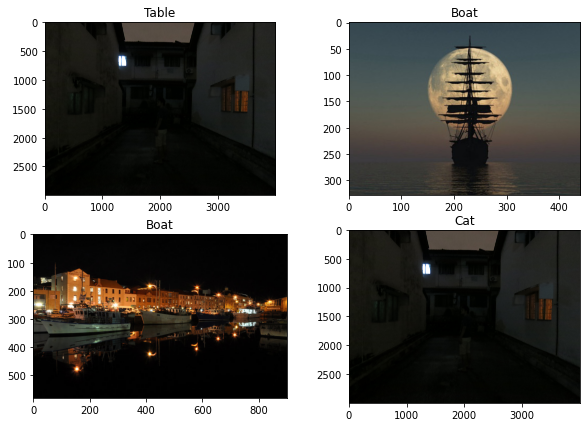

In [42]:


import matplotlib.image as mpimg

img1 = mpimg.imread('../input/image-datasets/'+test_data['File_Path'][209])
img2 = mpimg.imread('../input/image-datasets/'+test_data['File_Path'][400])
img3 = mpimg.imread('../input/image-datasets/'+test_data['File_Path'][187])
img4 = mpimg.imread('../input/image-datasets/'+test_data['File_Path'][279])
fig=plt.figure(figsize=(10,7))
r=2
c=2
fig.add_subplot(r,c,1)
plt.title(test_data['Class'][209])
plt.imshow(img1)


fig.add_subplot(r,c,2)
plt.title(test_data['Class'][400])
plt.imshow(img2)


fig.add_subplot(r,c,3)
plt.title(test_data['Class'][187])
plt.imshow(img3)


fig.add_subplot(r,c,4)
plt.title(test_data['Class'][279])
plt.imshow(img1)


